Image shape = (1424, 2144)
Number of Image: 11


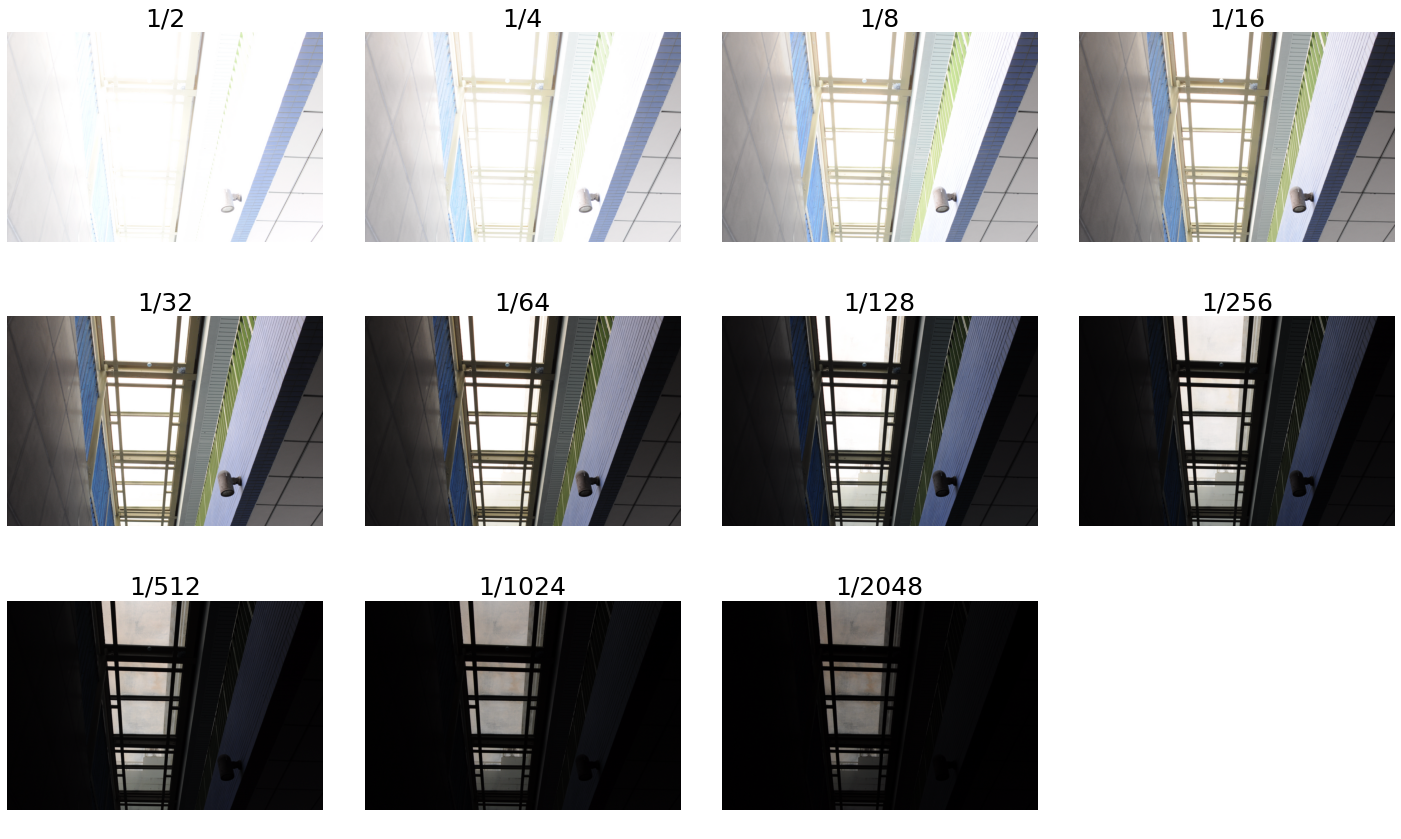

In [36]:
# Asignment: https://www.csie.ntu.edu.tw/~cyy/courses/vfx/21spring/assignments/proj1/
import cv2
import matplotlib.pyplot as plt
import os 
import random
import math
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker
import glob

SEED = 6666
MEDIAN_IGNORE_THRES = 1
N_SAMPLE = 300 #200 #  50
# SHUTTER_SPEED = [2, 4, 8, 15, 30, 60, 125, 250, 500, 1000, 2000] # '1/x'
SHUTTER_SPEED = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048] # '1/x'
# SHUTTER_SPEED = [1/32, 1/16, 1/8, 1/4, 1/2, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024] # memorial
INPUT_DIR =  "../data/original_image/"

random.seed(SEED)
fn_list = sorted(glob.glob(f"{INPUT_DIR}*.JPG"))

img_list =[cv2.imread(img_fn) for img_fn in fn_list] # BGR
N_IMAGE = len(img_list)
h, w = img_list[0].shape[:2]
print(f"Image shape = {(h, w)}")
print(f"Number of Image: {N_IMAGE}")

fig, ax = plt.subplots(math.ceil(N_IMAGE/4), 4, figsize=(20, 12))
fig.tight_layout()
[b.axis('off') for a in ax for b in a ]# Delete all axis
for i in range(len(img_list)):
    ax[int(i / 4), int(i % 4)].set_title( f"1/{SHUTTER_SPEED[i]}", fontsize=25)
    ax[int(i / 4), int(i % 4)].imshow(img_list[i])
plt.show()

## Image Aligement , MTB(Media Threshold Bitmap) algorithm

min_err = 0.0
best_dxy = (0, 0)
min_err = 0.0
best_dxy = (0, 0)
min_err = 0.0
best_dxy = (0, 0)
min_err = 0.0
best_dxy = (0, 0)
min_err = 0.0
best_dxy = (0, 0)
min_err = 0.0
best_dxy = (0, 0)
min_err = 0.0
best_dxy = (0, 0)
min_err = 0.0
best_dxy = (0, 0)
min_err = 0.0
best_dxy = (0, 0)
min_err = 0.0
best_dxy = (0, 0)
min_err = 0.0
best_dxy = (0, 0)


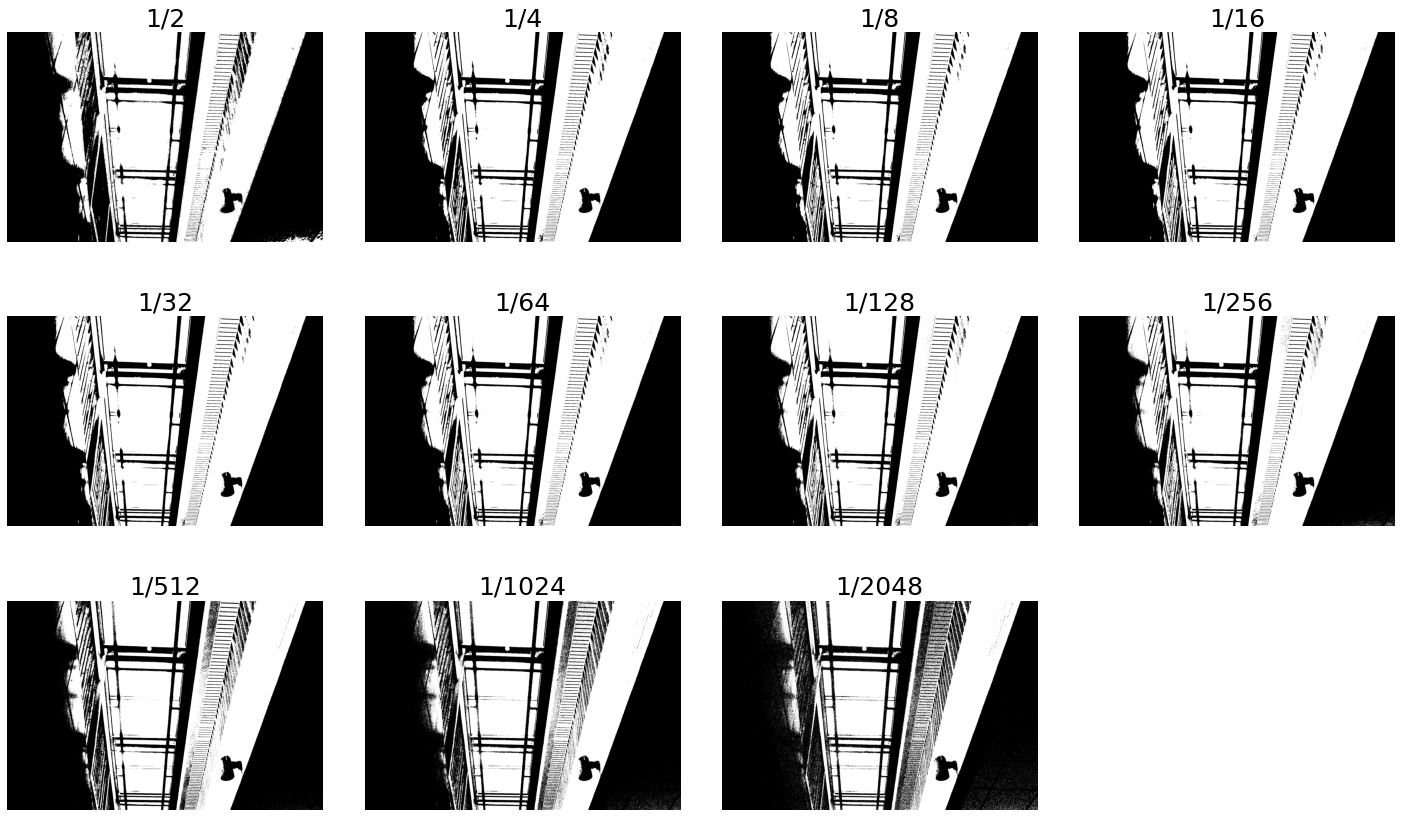

In [37]:
# Convert to gray scale, Y = (54R+183G+19B)/256

output_list = []
ignore_list = []
for img in img_list: 
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    median = np.median(gray_img)
    ret, thresh1 = cv2.threshold(gray_img, median, 255, cv2.THRESH_BINARY)
    output_list.append(thresh1)

    ignore_map = np.ones((h, w))
    ignore_map[np.where(np.abs(gray_img - median) <= MEDIAN_IGNORE_THRES)] = 0
    ignore_list.append(ignore_map)

min_err = 999999999999999999999999
best_dxy = None
for img in output_list:
    for dx in range(-5, 5):
        for dy in range(-5, 5):
            img_shifed = cv2.warpAffine(img, np.float32([[1,0,dx],[0,1,dy]]), (w ,h))
            err = np.sum(ignore_map * np.abs(img_shifed - output_list[0]))
            if err < min_err:
                min_err = err
                best_dxy = (dx, dy)
    print(f"min_err = {min_err}")
    print(f"best_dxy = {best_dxy}")

# Show images 
fig, ax = plt.subplots(math.ceil(N_IMAGE/4), 4, figsize=(20, 12))
fig.tight_layout()
[b.axis('off') for a in ax for b in a ]# Delete all axis
for i in range(len(output_list)):
    ax[int(i / 4), int(i % 4)].set_title( f"1/{SHUTTER_SPEED[i]}", fontsize=25)
    ax[int(i / 4), int(i % 4)].imshow(output_list[i], cmap=plt.get_cmap('gray'))
plt.show()


## Paul Debevec's method

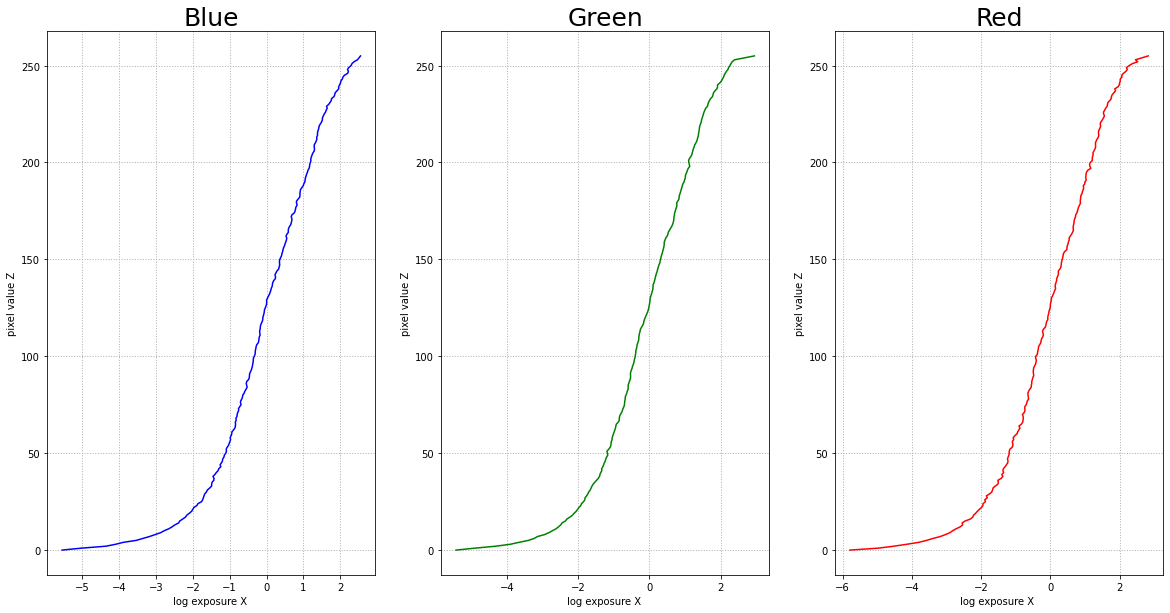

In [38]:
def f_weight(x): # weight function
    return 128 - abs(x - 127)

g_bgr = []
for channel in range(3):# BGR
    # Init A,b
    A = np.zeros([N_IMAGE*N_SAMPLE + 1 + 254, 256 + N_SAMPLE])
    b = np.zeros([N_IMAGE*N_SAMPLE + 1 + 254, 1])
    
    # Random sample point
    sample_x = random.sample(range(h), N_SAMPLE)
    sample_y = random.sample(range(w), N_SAMPLE)
    sample_pts = list(zip(sample_x, sample_y))
    
    # Build A, b(Ax = b)
    # Data fitting equations
    for i in range(N_SAMPLE):
        for j in range(N_IMAGE):
            n_row = i*N_IMAGE + j
            z = img_list[j][sample_pts[i][0], sample_pts[i][1]][channel]
            A[n_row, z]     =  f_weight(z) # 1
            A[n_row, 256+i] = -f_weight(z)# -1
            b[n_row, 0]     =  f_weight(z) * math.log( 1/SHUTTER_SPEED[j] )

    # g[127] = 0
    A[N_IMAGE*N_SAMPLE, 127] = 1

    # Smoothness equations
    for i in range(254):
        n_row = N_IMAGE*N_SAMPLE + 1 + i
        A[n_row, i]   = 1  * f_weight(i+1)
        A[n_row, i+1] = -2 * f_weight(i+1)
        A[n_row, i+2] = 1  * f_weight(i+1)
    
    A_inv = np.linalg.pinv(A)
    g = np.dot(A_inv, b)[:256]
    g_bgr.append(g)

# Show images 
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
channel_name = ['Blue', 'Green', 'Red']
for channel in range(3):
    c_n = channel_name[channel]
    ax[channel].set_title( f"{c_n}", fontsize=25)
    ax[channel].plot(g_bgr[channel], np.arange(256), c = c_n)
    ax[channel].set_xlabel('log exposure X ')
    ax[channel].set_ylabel('pixel value Z')
    ax[channel].grid(linestyle=':', linewidth=1)
plt.show()


## Recover Radiance Map

True

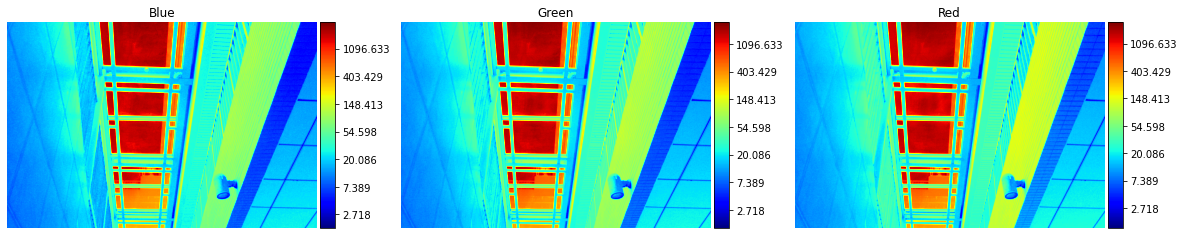

In [39]:
lnE_bgr = np.zeros((h, w, 3)).astype(np.float32)
for c in range(3): # Channel
    nume = np.zeros((h, w)).astype(np.float32)
    deno = np.zeros((h, w)).astype(np.float32)
    for p in range(len(img_list)):
        w_map = 128 - np.abs(img_list[p][:, :, c] - 127)
        img_1D = img_list[p][:, :, c].flatten()
        nume = nume + w_map * ( g_bgr[c][img_1D] - math.log(1/SHUTTER_SPEED[p]) ).reshape(h, w) 
        deno = deno + w_map
    lnE_bgr[:, :, c] = nume / deno

radiance_bgr = np.exp(lnE_bgr)

def fmt(x, pos):
    return '%.3f' % np.exp(x)

channel_name = ['Blue', 'Green', 'Red']
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
for c in range(3):
    im = ax[c].imshow(lnE_bgr[:, :, c], cmap='jet')
    ax[c].set_title(channel_name[c])
    ax[c].set_axis_off()
    divider = make_axes_locatable(ax[c])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax, format=ticker.FuncFormatter(fmt))

cv2.imwrite("../data/radiance.hdr", radiance_bgr)

## Tone Mapping

True

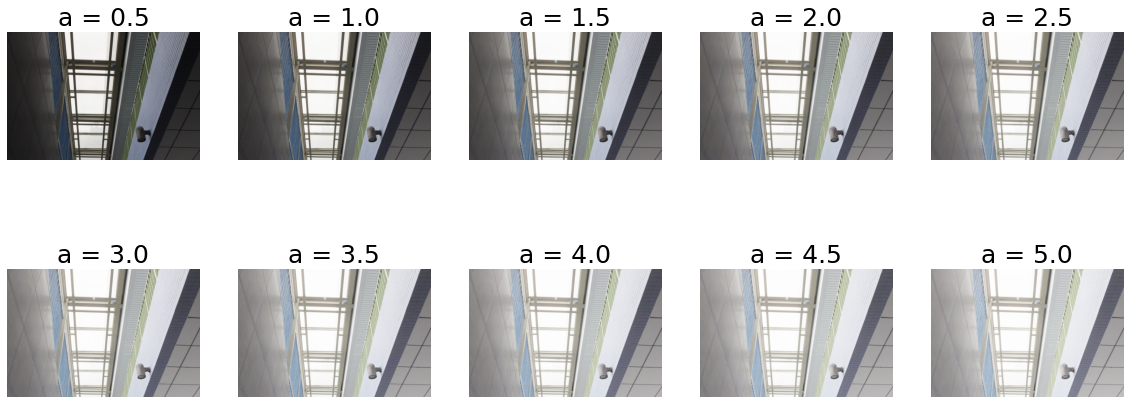

In [40]:
# Implement Photographic tone mapping
DELTA = 1e-10
A = (0.5, 5.5) # high/Low-key range
a_increment = (A[1]-A[0])/10
L_d_global_list = []
for a in np.arange(A[0], A[1], a_increment):
    L_d_global = np.zeros((h, w, 3)).astype(np.float32)
    # Global operator 
    for c in range(3):
        L_write = np.max(radiance_bgr[:, :, c])
        L_w_bar = np.exp( np.sum(np.log(radiance_bgr[:, :, c] + DELTA)) / (h*w) )
        L_m = (a/L_w_bar) * radiance_bgr[:, :, c]
        L_d_global[:, :, c] = (L_m * (1 + (L_m/L_write**2))) / (1 + L_m)
    L_d_global_list.append(L_d_global)

fig, ax = plt.subplots(2, 5, figsize=(20, 8))
for i in range(10):
    im = ax[i//5, i%5].imshow(L_d_global_list[i])
    ax[i//5, i%5].set_title(f"a = {A[0]+i*a_increment}", fontsize=25)
    ax[i//5, i%5].set_axis_off()

cv2.imwrite("../data/tonemap_my_implemented_reinhard.png", L_d_global_list[3] * 255)

In [41]:
# Opencv tone-mapping methods
# Reference: https://zhuanlan.zhihu.com/p/38176640

radiance = radiance_bgr # radiance_debevec
tonemapDrago = cv2.createTonemapDrago(2.0, 0.7)
ldrDrago = tonemapDrago.process(radiance)
cv2.imwrite("../data/tonemap_drago.png", ldrDrago * 255)

tonemapReinhard = cv2.createTonemapReinhard(3, 0, 0, 0)
ldrReinhard = tonemapReinhard.process(radiance)
cv2.imwrite("../data/tonemap_reinhard.png", ldrReinhard * 255)

tonemapMantiuk = cv2.createTonemapMantiuk(3.5, 0.85, 1.2)
ldrMantiuk = tonemapMantiuk.process(radiance)
cv2.imwrite("../data/tonemap_mantiuk.png", ldrMantiuk * 255)


True

## Robertson method

Iteration: 1/3
Iteration: 2/3
Iteration: 3/3
Iteration: 1/3
Iteration: 2/3
Iteration: 3/3
Iteration: 1/3
Iteration: 2/3
Iteration: 3/3


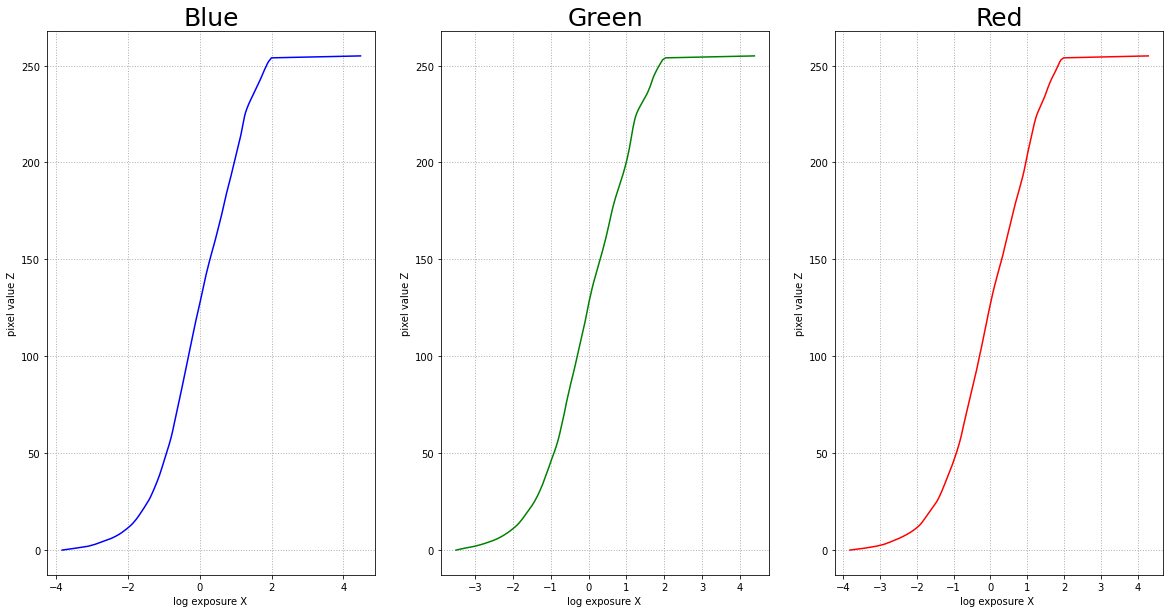

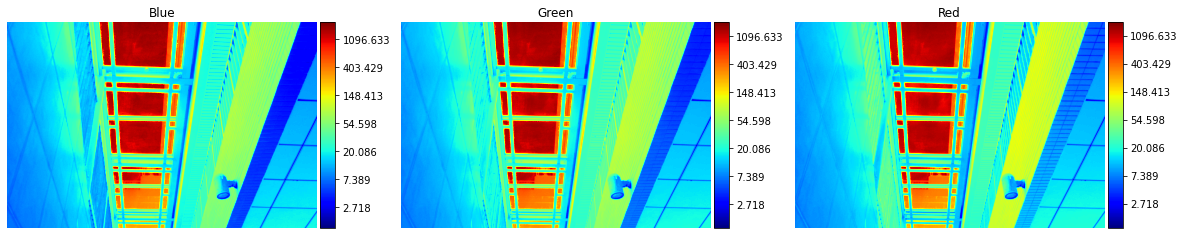

In [42]:
N_ITERATE = 3
g_bgr_robert = [[], [], []]
E_bgr_robert = np.zeros((h, w, 3)).astype(np.float32)

# Init g_bgr_robert, make it a 45 degree staright line
for c in range(3):
    g_bgr_robert[c] = np.arange(-6, 3, 9/256) # This is setting by Debevec method's result
# find Ei first, so we don't need to init Ei

for c in range(3): # channels
    for i in range(N_ITERATE):
        # Fix g(Z), find Ei
        nume = np.zeros((h, w)).astype(np.float32)
        deno = np.zeros((h, w)).astype(np.float32)
        for p in range(N_IMAGE):
            w_map = 128 - np.abs(img_list[p][:, :, c] - 127)
            img_1D = img_list[p][:, :, c].flatten()
            nume = nume + w_map * ( g_bgr_robert[c][img_1D] * (1/SHUTTER_SPEED[p]) ).reshape(h, w)
            deno = deno + w_map * ( (1/SHUTTER_SPEED[p])**2 )
        E_bgr_robert[:, :, c] = nume / deno
        
        # Fix Ei, find g(Z)
        nume = 0
        deno = 0
        E_1D   = E_bgr_robert[:, :, c].flatten()
        for m in range(256): # find specific lightness pixels
            for p in range(N_IMAGE):
                img_1D = img_list[p][:, :, c].flatten()
                idx = np.where(img_1D == m)
                nume += np.sum(E_1D[idx]) * (1/SHUTTER_SPEED[p])
                deno += idx[0].size
        
            g_bgr_robert[c][m] = nume / deno
        g_bgr_robert[c] /= g_bgr_robert[c][127] # normalize by g[127]

        print(f"Iteration: {i+1}/{N_ITERATE}")

# Show Response curve 
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
channel_name = ['Blue', 'Green', 'Red']
for channel in range(3):
    c_n = channel_name[channel]
    ax[channel].set_title( f"{c_n}", fontsize=25)
    ax[channel].plot(np.log(g_bgr_robert[channel]), np.arange(256), c = c_n)
    ax[channel].set_xlabel('log exposure X ')
    ax[channel].set_ylabel('pixel value Z')
    ax[channel].grid(linestyle=':', linewidth=1)
plt.show()

# Show Radient map
def fmt(x, pos):
    return '%.3f' % np.exp(x)

channel_name = ['Blue', 'Green', 'Red']
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
for c in range(3):
    im = ax[c].imshow(np.log(E_bgr_robert[:, :, c]), cmap='jet')
    ax[c].set_title(channel_name[c])
    ax[c].set_axis_off()
    divider = make_axes_locatable(ax[c])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax, format=ticker.FuncFormatter(fmt))


## Opencv2 Debevec's method

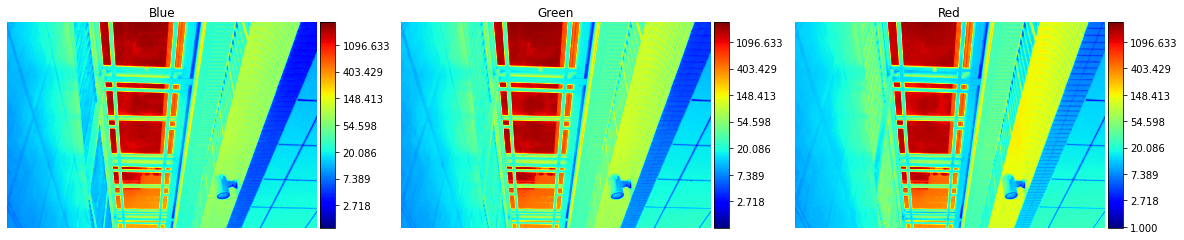

In [43]:
# Reference: https://www.twblogs.net/a/5cc881d6bd9eee1ac30b9ce7

time = np.array([1/i for i in SHUTTER_SPEED]).astype(np.float32)
calibrateDebevec = cv2.createCalibrateDebevec()
responseDebevec = calibrateDebevec.process(img_list, time )
# Merge images into an HDR linear image
mergeDebevec = cv2.createMergeDebevec()
hdrDebevec = mergeDebevec.process(img_list, time, responseDebevec)

# Plt show HDR
channel_name = ['Blue', 'Green', 'Red']
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
for c in range(3):
    im = ax[c].imshow(np.log(hdrDebevec[:, :, c]), cmap='jet')
    ax[c].set_title(channel_name[c])
    ax[c].set_axis_off()
    divider = make_axes_locatable(ax[c])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax, format=ticker.FuncFormatter(fmt))
